In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns # for nooiiice plots
import sys #used to make a progress bar
np.random.seed(0) # for consistency in shuffling

In [2]:
d = np.genfromtxt('S1train.csv',skip_header=1,delimiter=',')

In [3]:
def euclid_dist(p1,p2):
    """
    returns the euclidean distance between p1 and p2
    p1 and p2 are nunpy arrays of the features
    """
#     print(p1)
#     print()
#     print(p2)
    return np.sqrt(np.sum((p1-p2)**2))
def euclid_case_to_training(x, ts):
    """
    computes the euclidean distance between the particular case x and the training set ts
    assumes ts has rows with [class, feature 1, feature 2]
    Answer to problem 1. b.
    """
#     print('CASE ts: ')
#     print(ts)
#     print('\n ts:')
#     print(ts)
#     print('ts cols')

#     print(ts[:,[1,2]])
    return np.apply_along_axis(euclid_dist, 1, ts[:,[1,2]],p2=x)
def k_dist(x, ts, K):
    """
    returns the indices of the K nearest neighbors to x in the training set
    assumes ts has rows with [class, feature 1, feature 2]

    """

    return np.argsort(euclid_case_to_training(x,ts))[:K]
def majority_class(x, ts, K):
    """
    takes a training point, test set, and a value of K for K means. Returns the majority class of 
    the K points nearest to the x
    
    This implementation works best for binary classes. For problems with more classes it would be better
    to use scipy.stats.mode. I didn't use that here because that felt dirty.
    """

    return [np.where(np.mean(ts[:,0][k_dist(x,ts,K)]) >= 0.0, 1, -1)]



def predict(pred, ts, K):
    """
    returns a vector of predictions given a list of feature vectors and a training set
    """
    return np.apply_along_axis(majority_class, 1, pred, ts=ts,K=K)
def misclass_rate(labels, ground_truth):
    """
    returns the missclassification rate
    """
    return 1-np.sum(np.concatenate(labels)==ground_truth)/len(labels)
def cross_validation(ts, n=10,K=5):
    """
    returns the average missclassificaiton error across the n folds of data
    """
    np.random.shuffle(ts)
    n_folds = np.asarray(np.array_split(ts, n))
    index = np.arange(n)
    total = 0
    for i in range(n):
        for j in range(n):
            if i == j:
                continue    
            total += misclass_rate(predict(n_folds[i][:,[1,2]],
                                  np.concatenate(n_folds[index != i]),K),n_folds[i][:,0])
    return total/(n-1)**2
    


# 1. K Fold validation
doing it with S2 set and above functions

### S1

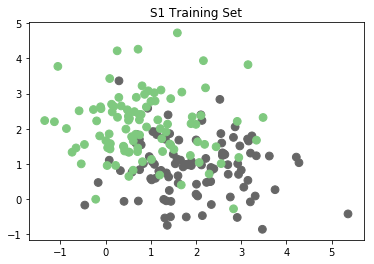

In [4]:
#load data
S1_train = np.genfromtxt('S1train.csv',skip_header=1,delimiter=',')
S1_test = np.genfromtxt('S1test.csv',skip_header=1,delimiter=',')

#plot training data
plt.scatter(x=S1_train[:,1], y=S1_train[:,2], c=S1_train[:,0],s=60,cmap='Accent')
plt.title('S1 Training Set')
plt.show()

[====================] 25/25 K values attempted  

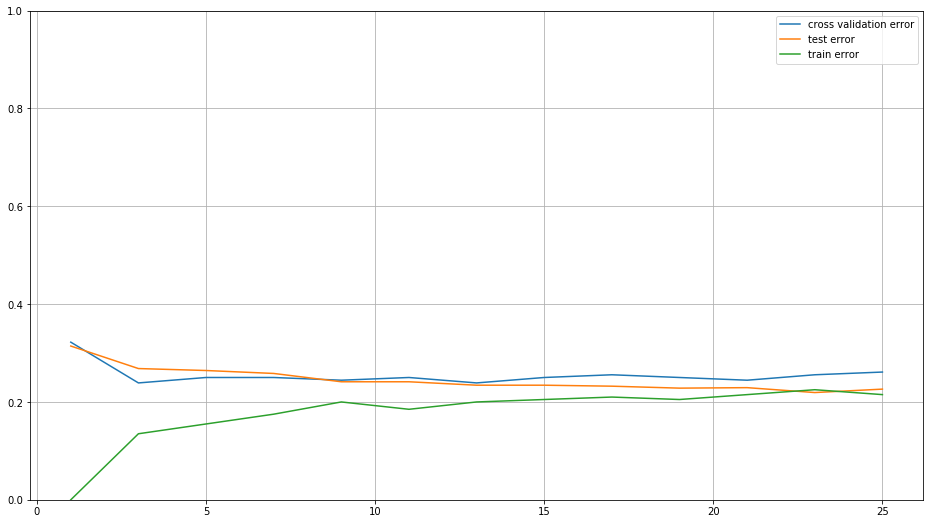

Wall time: 1min 41s


In [5]:
%%time
cv_error = []
tst_error = []
train_error = []
max_K = 25
ks = np.arange(1,max_K+2,step=2)

for k in ks:
    cv_error.append(cross_validation(ts = S1_train, n =10, K = k))
    tst_error.append(misclass_rate(predict(S1_test[:,1:],S1_train,K=k),S1_test[:,0]))
    train_error.append(misclass_rate(predict(S1_train[:,1:],S1_train,K=k),S1_train[:,0]))
    sys.stdout.write('\r')
    eq = int(np.ceil(np.true_divide(k*100,max_K*5)))
    sys.stdout.write("[{:20s}] {}/{} K values attempted  ".format('='*eq, k,max_K))
plt.figure(figsize=(16,9))
plt.plot(ks, cv_error,label='cross validation error')
plt.plot(ks, tst_error,label='test error')
plt.plot(ks, train_error,label='train error')
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.show()

### S2

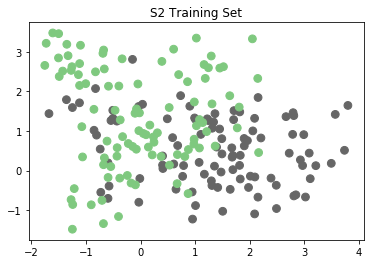

In [6]:
#load data
S2_train = np.genfromtxt('S2train.csv',skip_header=1,delimiter=',')
S2_test = np.genfromtxt('S2test.csv',skip_header=1,delimiter=',')

#plot training data
plt.scatter(x=S2_train[:,1], y=S2_train[:,2], c=S2_train[:,0],s=60,cmap='Accent')
plt.title('S2 Training Set')

[====================] 25/25 K values attempted  

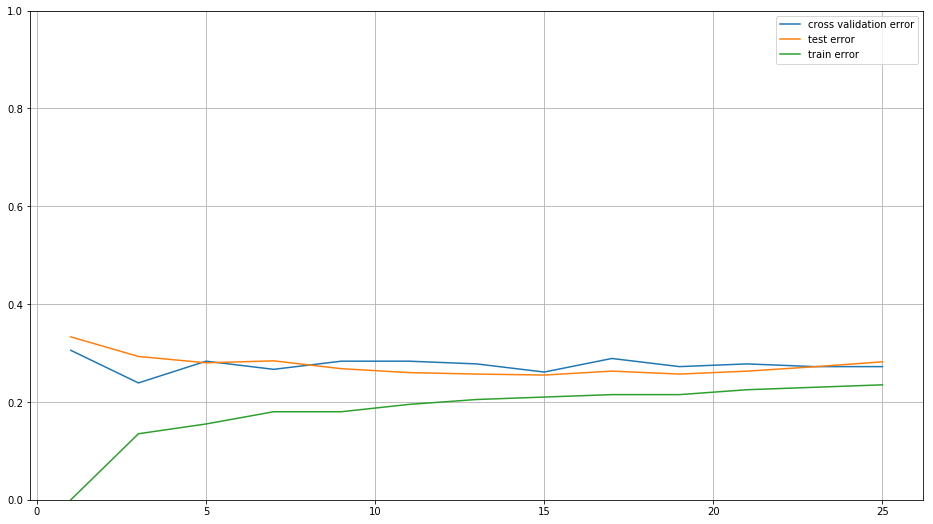

Wall time: 1min 38s


In [7]:
%%time
cv_error = []
tst_error = []
train_error = []
max_K = 25
ks = np.arange(1,max_K+2,step=2)

for k in ks:
    cv_error.append(cross_validation(ts = S2_train, n =10, K = k))
    tst_error.append(misclass_rate(predict(S2_test[:,[1,2]],S2_train,K=k),S2_test[:,0]))
    train_error.append(misclass_rate(predict(S2_train[:,[1,2]],S2_train,K=k),S2_train[:,0]))
    sys.stdout.write('\r')
    eq = int(np.ceil(np.true_divide(k*100,max_K*5)))
    sys.stdout.write("[{:20s}] {}/{} K values attempted  ".format('='*eq, k,max_K))
plt.figure(figsize=(16,9))
plt.plot(ks, cv_error,label='cross validation error')
plt.plot(ks, tst_error,label='test error')
plt.plot(ks, train_error,label='train error')
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.show()

# Rewrite K Nearest with Lookup table
I rewrote my K - nearest neighbors

In [8]:
def majority_class_lookup(dist, ts, K):
    """
    takes a training point, test set, and a value of K for K means. Returns the majority class of 
    the K points nearest to the x.
    
    Unlike majority_class this one accepts a lookup table of distances
    
    This implementation works best for binary classes. For problems with more classes it would be better
    to use scipy.stats.mode. I didn't use that here because that felt dirty.
    """
    from scipy.stats import mode
    return mode(ts[:,0][dist[:K]])[0]
def predict_lookup(pred, ts, K):
    """
    returns a vector of predictions given a list of feature vectors and a training set
    """
    from scipy.spatial.distance import cdist
    dist = cdist(pred,ts[:,1:])
    k_dist = np.argsort(dist)

    a = np.apply_along_axis(majority_class_lookup, 1, k_dist, ts=ts,K=K)
    return a
def misclass_rate(labels, ground_truth):
    """
    returns the missclassification rate
    """
    return 1-np.sum(np.equal(np.concatenate(labels),ground_truth))/len(labels)
def cross_validation_lookup(ts, n=10,K=5):
    """
    returns the average missclassificaiton error across the n folds of data
    """
    np.random.shuffle(ts)
    n_folds = np.asarray(np.array_split(ts, n))
    index = np.arange(n)
    total = 0
    for i in range(n):
        for j in range(n):
            if i == j:
                continue   
            
            total += misclass_rate(predict_lookup(n_folds[i][:,1:],
                                  np.concatenate(n_folds[index != i]),K),n_folds[i][:,0])
    return total/(n*(n-1))


### Problem 1 now runs much quicker

[====================] 25/25 K values attempted  

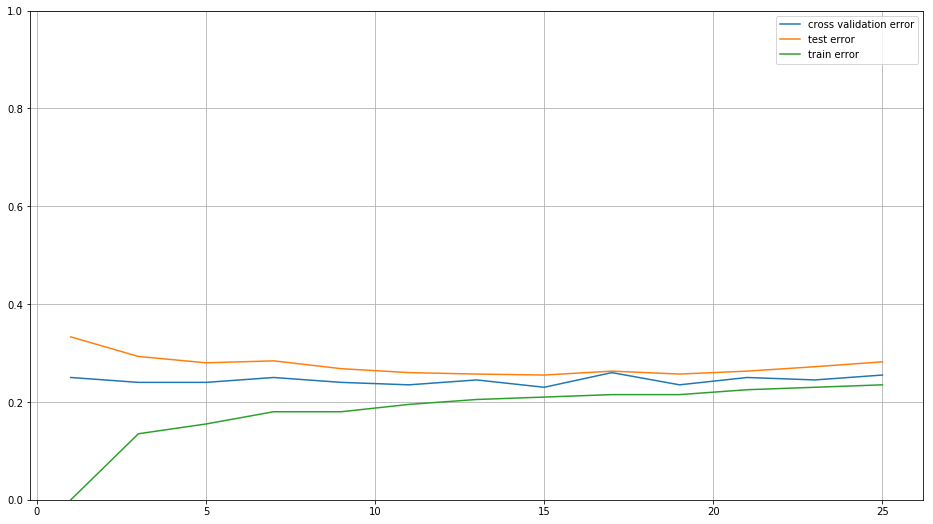

Wall time: 4.68 s


In [9]:
%%time
S2_train = np.genfromtxt('S2train.csv',skip_header=1,delimiter=',')
cross_validation_lookup(S2_train)

cv_error = []
tst_error = []
train_error = []
max_K = 25
ks = np.arange(1,max_K+2,step=2)

for k in ks:
    cv_error.append(cross_validation_lookup(ts = S2_train, n =10, K = k))
    tst_error.append(misclass_rate(predict_lookup(S2_test[:,[1,2]],S2_train,K=k),S2_test[:,0]))
    train_error.append(misclass_rate(predict_lookup(S2_train[:,[1,2]],S2_train,K=k),S2_train[:,0]))
    sys.stdout.write('\r')
    eq = int(np.ceil(np.true_divide(k*100,max_K*5)))
    sys.stdout.write("[{:20s}] {}/{} K values attempted  ".format('='*eq, k,max_K))
plt.figure(figsize=(16,9))
plt.plot(ks, cv_error,label='cross validation error')
plt.plot(ks, tst_error,label='test error')
plt.plot(ks, train_error,label='train error')
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.show()

# Problem 2

need to prep the data first but then I can just apply the same algorithim.

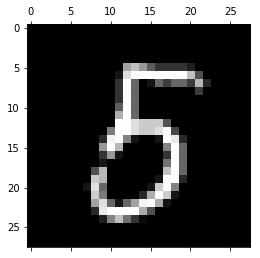

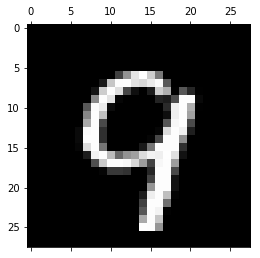

[[ 5.  0.  0. ...,  0.  0.  0.]
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 5.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 5.  0.  0. ...,  0.  0.  0.]]


In [99]:
d_5 = np.genfromtxt('Train5.csv',skip_header=1,delimiter=',')
d_9 = np.genfromtxt('Train9.csv',skip_header=1,delimiter=',')

# lets visualize!
plt.matshow(d_5[3].reshape(28,28),cmap='gray')
plt.show()
plt.matshow(d_9[3].reshape(28,28),cmap='gray')
plt.show()

# add on classification
d_5 = np.insert(d_5, 0, 5, axis=1)
print(d_5)
d_9 = np.insert(d_9, 0, 9, axis=1)

#combine into big training set
train_set = np.concatenate((d_5,d_9))
np.random.shuffle(train_set)


[====================] 25/25 K values attempted  

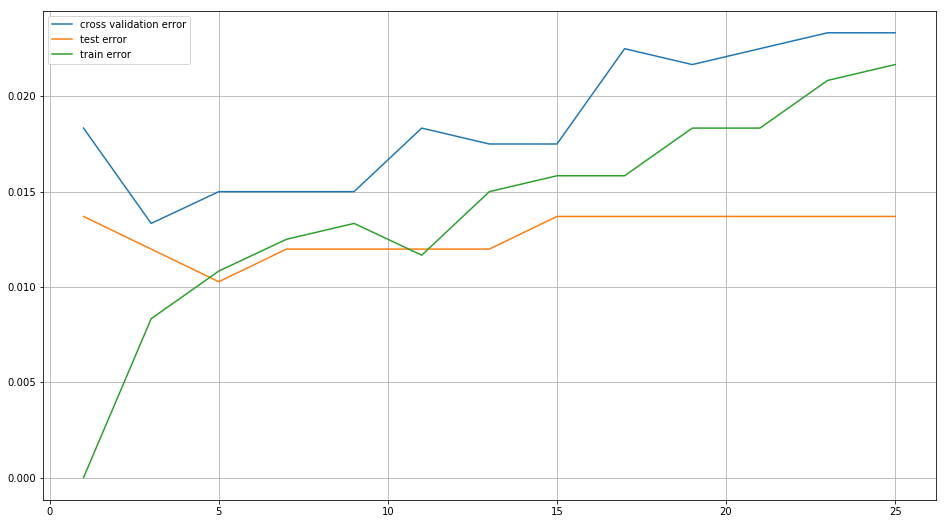

Wall time: 4min 32s


In [11]:
%%time
tst_5 = np.genfromtxt('Test5.csv',skip_header=1,delimiter=',')
tst_9 = np.genfromtxt('Test9.csv',skip_header=1,delimiter=',')
tst_5 = np.insert(tst_5, 0, 5, axis=1)
tst_9 = np.insert(tst_9, 0, 9, axis=1)
test_set = np.concatenate((tst_5,tst_9))

cv_error = []
tst_error = []
train_error = []
max_K = 25
ks = np.arange(1,max_K+2,step=2)

for k in ks:
    cv_error.append(cross_validation_lookup(ts = train_set, n =10, K = k))
    tst_error.append(misclass_rate(predict_lookup(test_set[:,1:],train_set,K=k),test_set[:,0]))
    train_error.append(misclass_rate(predict_lookup(train_set[:,1:],train_set,K=k),train_set[:,0]))
    sys.stdout.write('\r')
    eq = int(np.ceil(np.true_divide(k*100,max_K*5)))
    sys.stdout.write("[{:20s}] {}/{} K values attempted  ".format('='*eq, k,max_K))
plt.figure(figsize=(16,9))
plt.plot(ks, cv_error,label='cross validation error')
plt.plot(ks, tst_error,label='test error')
plt.plot(ks, train_error,label='train error')
plt.legend()
plt.grid()
plt.show()

This time could easily be improved upon by calculating the distances between the folds of the cross validation set once before the slicing. However this would have required modifying my predictor function in a way that I feel would make it less robust as when you do the testing you don't do the folds. So point is I didn't bother...

# Problem 3

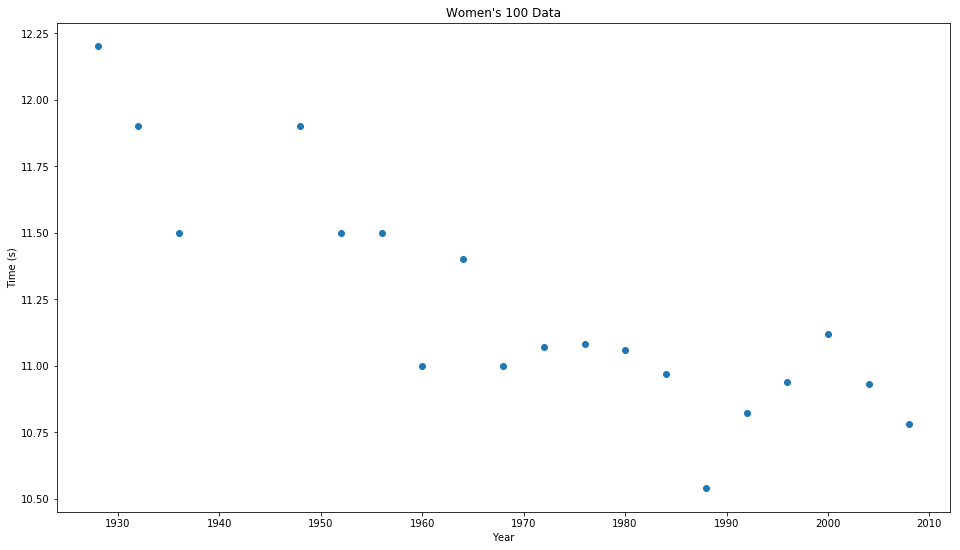

In [39]:
#load and visualize data
d = np.loadtxt('womens100.csv',delimiter=',')
plt.figure(figsize=(16,9))
plt.title("Women's 100 Data")
plt.scatter(d[:,0],d[:,1])
plt.xlabel('Year')
plt.ylabel('Time (s)')
plt.show()


In [46]:
def OLS(x, t):
    """
    Ordinry least squares regression algorithim
    Accepts: two numpy arrays of shape (N,)
    Returns (w0, w1) that correspond to a linear model of tn = w0 + w1 * xn as a best fit line
    """
    w1 =np.dot(x-np.mean(x),t-np.mean(t))/np.sum((x-np.mean(x))**2)
    w0 = np.mean(t)-w1*np.mean(x)
    return (w0,w1)
(w0, w1) = OLS(d[:,0],d[:,1])
print("w0 = {:}".format(w0))
print("w1 = {:}".format(w1))

w0 = 40.92415460065391
w1 = -0.015071812237272308


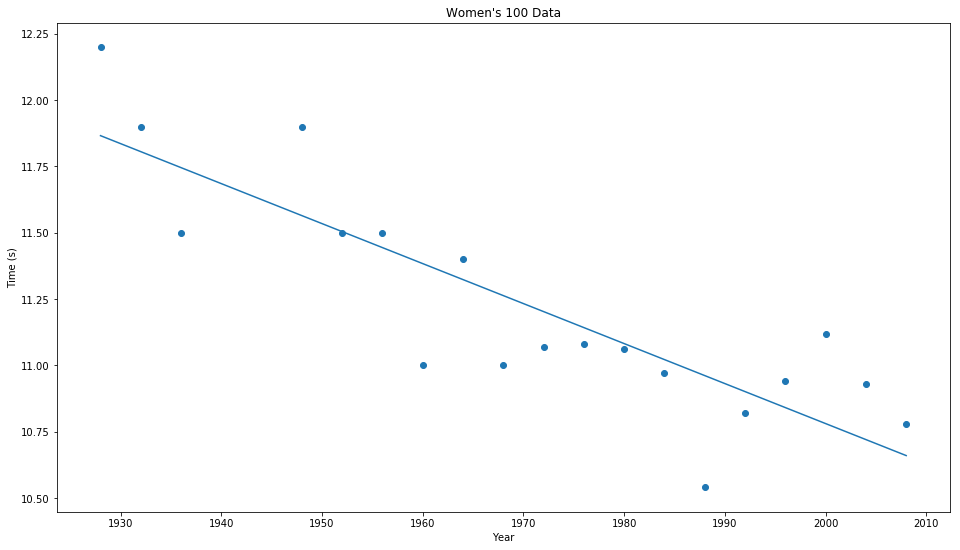

In [38]:
x = np.linspace(d[:,0][0],d[:,0][-1],100)
y = w0 + w1*x
plt.figure(figsize=(16,9))
plt.title("Women's 100 Data")
plt.plot(x,y)
plt.scatter(d[:,0],d[:,1])
plt.xlabel('Year')
plt.ylabel('Time (s)')
plt.show()


### Comparing to lmfit
lmfit is my prefered python least squares regression solver as it prints out fit information quite nicely.
It is based on algorithims in scipy and so should return good values

https://lmfit.github.io/lmfit-py/index.html

In [55]:
from lmfit.models import LinearModel


mod = LinearModel()

pars = mod.guess(d[:,1], x=d[:,0])
res  = mod.fit(y, pars, x=x)
print(res.fit_report())


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 100
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -inf
    Bayesian info crit = -inf
[[Variables]]
    slope:      -0.01507181 +/- 0        (0.00%) (init=-0.01507181)
    intercept:   40.9241546 +/- 0        (0.00%) (init= 40.92415)
[[Correlations]] (unreported correlations are <  0.100)



### Comparing Fit parameters

I originally checked with np.isclose which allows for a small tolerance however my solution and the off the shelf
solution are close enough such that np.equal works.

In [51]:
lmfit_fit = [res.best_values['intercept'], res.best_values['slope']]
print(np.equal([w0,w1],lmfit_fit))

[ True  True]


### Predicting 2012 and 2016

In [56]:
# 2012

print("2012: "+ str(w0+2012*w1))

#2016
print("2016: "+ str(w0+2016*w1))

#Actual results

print("Actual Results:")
print("2012:  10.75")
print("2016: 10.71")




2012: 10.5996683793
2016: 10.5393811303
Actual Results:
2012:  10.75
2016: 10.71


#### Comparison

I don't think a linear model captures the underlying phenomenon best here as humans cannot improve speed at a constant rate. So it is reasonable that our model underestimates the time it should take.

#### multiple input variables

(4, 19)
[[ -1.89287507e+04]
 [  2.93156681e+01]
 [ -1.51125474e-02]
 [  2.59480925e-06]]


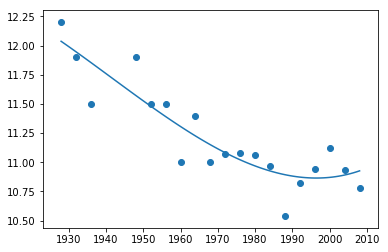

In [151]:
def OLS(x,t):
    """
    Ordinry least squares regression algorithim
    Accepts: two numpy arrays of shape (N,)
    Returns (w0, w1) that correspond to a linear model of tn = w0 + w1 * xn as a best fit line
    """
#     print(x)
#     print(x.shape)
#     print(np.dot(x.T,x))
#     print(np.linalg.inv(np.dot(x.T,x)))
    a = np.dot(np.linalg.inv(np.dot(x.T,x)),x.T)
    print(a.shape)
    print(np.dot(a,t.T))
    return np.dot(a,t.T)

x= d[:,0]
# print(x.ndim)
x_new = np.zeros((len(x),4))
x_new[:, 0] = 1
x_new[:, 1] = np.column_stack(x)
x_new[:, 2] = np.column_stack(x**2)
x_new[:, 3] = np.column_stack(x**3)

# print(x_new)
w = OLS(x_new,np.column_stack(d[:,1]))
x = np.linspace(d[:,0][0],d[:,0][-1],100)
y = w[0] + w[1]*x+w[2]*x**2+w[3]*x**3
plt.plot(x,y)
plt.scatter(d[:,0],d[:,1])

In [114]:
x= d[:,0]
# print(x.ndim)
x_new = np.zeros((len(x),2))
x_new[:, 0] = np.column_stack(x)
x_new[:, 1] = np.column_stack(x**2)
print(x_new)
OLS(x_new,np.column_stack(d[:,1]))

[[  1.92800000e+03   3.71718400e+06]
 [  1.93200000e+03   3.73262400e+06]
 [  1.93600000e+03   3.74809600e+06]
 [  1.94800000e+03   3.79470400e+06]
 [  1.95200000e+03   3.81030400e+06]
 [  1.95600000e+03   3.82593600e+06]
 [  1.96000000e+03   3.84160000e+06]
 [  1.96400000e+03   3.85729600e+06]
 [  1.96800000e+03   3.87302400e+06]
 [  1.97200000e+03   3.88878400e+06]
 [  1.97600000e+03   3.90457600e+06]
 [  1.98000000e+03   3.92040000e+06]
 [  1.98400000e+03   3.93625600e+06]
 [  1.98800000e+03   3.95214400e+06]
 [  1.99200000e+03   3.96806400e+06]
 [  1.99600000e+03   3.98401600e+06]
 [  2.00000000e+03   4.00000000e+06]
 [  2.00400000e+03   4.01601600e+06]
 [  2.00800000e+03   4.03206400e+06]]


AttributeError: module 'numpy.linalg' has no attribute 'inverse'

# Problem 4

In [70]:
print(d.shape)
np.insert(d,0,1,axis=1)

(19, 2)


array([[  1.00000000e+00,   1.92800000e+03,   1.22000000e+01],
       [  1.00000000e+00,   1.93200000e+03,   1.19000000e+01],
       [  1.00000000e+00,   1.93600000e+03,   1.15000000e+01],
       [  1.00000000e+00,   1.94800000e+03,   1.19000000e+01],
       [  1.00000000e+00,   1.95200000e+03,   1.15000000e+01],
       [  1.00000000e+00,   1.95600000e+03,   1.15000000e+01],
       [  1.00000000e+00,   1.96000000e+03,   1.10000000e+01],
       [  1.00000000e+00,   1.96400000e+03,   1.14000000e+01],
       [  1.00000000e+00,   1.96800000e+03,   1.10000000e+01],
       [  1.00000000e+00,   1.97200000e+03,   1.10700000e+01],
       [  1.00000000e+00,   1.97600000e+03,   1.10800000e+01],
       [  1.00000000e+00,   1.98000000e+03,   1.10600000e+01],
       [  1.00000000e+00,   1.98400000e+03,   1.09700000e+01],
       [  1.00000000e+00,   1.98800000e+03,   1.05400000e+01],
       [  1.00000000e+00,   1.99200000e+03,   1.08200000e+01],
       [  1.00000000e+00,   1.99600000e+03,   1.0940000